<h1 align="center">Volume 4: Inverse Problems.</h1>

    Marcelo Leszynski
    Math 439 Sec 002
    03/10/22

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Code from RK4 Lab with minor edits
def initialize_all(y0, t0, t, n):
    """ An initialization routine for the different ODE solving
    methods in the lab. This initializes Y, T, and h. """
    if isinstance(y0, np.ndarray):
        Y = np.empty((n, y0.size)).squeeze()
    else:
        Y = np.empty(n)
    
    Y[0] = y0
    T = np.linspace(t0, t, n)
    h = float(t - t0) / (n - 1)
    return Y, T, h

def RK4(f, y0, t0, t, n):
    """ Use the RK4 method to compute an approximate solution
    to the ODE y' = f(t, y) at n equispaced parameter values from t0 to t
    with initial conditions y(t0) = y0.
    
    y0 is assumed to be either a constant or a one-dimensional numpy array.
    t and t0 are assumed to be constants.
    f is assumed to accept three arguments.
    The first is a constant giving the value of t.
    The second is a one-dimensional numpy array of the same size as y.
    The third is an index to the other arrays.
    
    This function returns an array Y of shape (n,) if
    y is a constant or an array of size 1.
    It returns an array of shape (n, y.size) otherwise.
    In either case, Y[i] is the approximate value of y at
    the i'th value of np.linspace(t0, t, n).
    """
    Y,T,h = initialize_all(y0,t0,t,n)
    for i in range(n-1):
        K1 = f(T[i],Y[i],i)
        K2 = f(T[i]+h/2.,Y[i]+h/2.*K1,i)
        K3 = f(T[i]+h/2.,Y[i]+h/2.*K2,i)
        K4 = f(T[i+1],Y[i]+h*K3,i)
        Y[i+1] = Y[i] + h/6.*(K1+2*K2 +2*K3+K4)
    return Y

# Problem 1

Create a function that defines the state equations and returns both equations in
a single array. The function should be able to be passed into the RK4 solver.

In [3]:
# define constants

a_1, a_2 = 0, 0
b_1, b_2 = 0.02, 0.9
s_1, s_2 = 2., 1.5
mu = 0.002
k = 0.000025    # The paper uses .00025, but it's hard to determine which solution actually makes sense.
g = 30.
c = 0.007
B_1, B_2 = 14, 1
A_1, A_2 = 250000, 75
T0, V0 = 400, 3
t_f = 50
n = 2000

state = np.zeros((n, 2))
state0 = np.array([T0, V0])

costate = np.zeros((n, 2))
costate0 = np.zeros(2)

u=np.zeros((n, 2))
u[:, 0] += .02
u[:, 1] += .9

# define state equations
def state_equations(t,y,i):
    '''
    Parameters
    ---------------
    t : float
        the time
    y : ndarray (2,)
        the T cell concentration and the Virus concentration at time t
    i : int
        index for the global variable u.
    
    Returns
    --------------
    y_dot : ndarray (2,)
            the derivative of the T cell concentration and the virus
            concentration at time t
    '''
    # calculate both state equations ###################################
    T_t, V_t = y
    T_p = s_1 - ((s_2*V_t)/(B_1 + V_t)) - (mu*T_t) - (k*V_t*T_t) + (u[i, 0]*T_t)
    V_p = ((g*V_t)/(B_2 + V_t))*(1 - u[i, 1]) - (c*V_t*T_t)
    
    return np.array([T_p, V_p]) 

# Problem 2

Create a function that defines the costate equations and returns both equations
in a single array. The function should be able to be passed into the RK4 solver. Use the global
variables as defined in Problem 1.

In [4]:
def lambda_hat(t,y,i):
    '''
    Parameters
    ---------------
    t : float
    the time
    y : ndarray (2,)
    the lambda_hat values at time t
    i : int
    index for global variables, u and state.
    Returns
    --------------
    y_dot : ndarray (2,)
    the derivative of the lambda_hats at time t.
    '''
    # calculate both costate equations #################################
    l_1, l_2 = y
    T, V = state[-i - 1]
    lambhat_1 = l_1*(-mu - (k*V) + u[-i - 1, 0]) - (c*l_2*V) + 1
    lambhat_2 = -l_1*(((s_2*B_1)/((B_1 + V)**2)) + (k*T)) +\
        l_2*(((g*B_2*(1 - u[-i - 1, 1]))/((B_2 + V)**2)) - (c*T))
    
    return np.array([lambhat_1,lambhat_2])

# Problem 3

Create and run a numerical solver for the HIV two drug model. Plot the solution.

In [5]:
epsilon = 0.001
test = epsilon + 1
while(test > epsilon):
    oldu = u.copy();
    
    #solve the state equations with forward iteration
    state = RK4(state_equations, state0, 0, t_f, n)
    
    #solve the costate equations with backwards iteration
    costate = RK4(lambda_hat, costate0, 0, t_f, n)[::-1]
    
    #solve for u1 and u2
    u1 = np.minimum(np.maximum(a_1, (1/(2*A_1))*(costate[:, 0]*state[:, 0])), b_1)
    u2 = np.minimum(np.maximum(a_2, (-costate[:, 1]/(2*A_2))*\
                               (g*state[:, 1]/(B_2 + state[:, 1]))), b_2)
    
    #update control
    u[:,0] = 0.5*(u1 + oldu[:,0])
    u[:,1] = 0.5*(u2 + oldu[:,1])
    
    #test for convergence
    test = abs(oldu - u).sum()

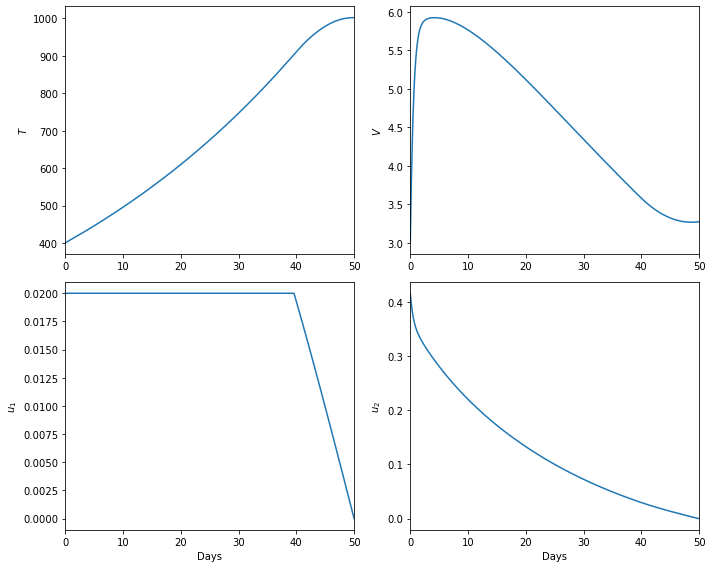

In [6]:
# plot results of solver ###############################################
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
r = np.linspace(0, t_f, n)

ax[0, 0].plot(r, state[:, 0])
ax[0, 0].set_ylabel('$T$')
ax[0, 0].set_xlim([0, 50])

ax[0, 1].plot(r, state[:, 1])
ax[0, 1].set_ylabel('$V$')
ax[0, 1].set_xlim([0, 50])

ax[1, 0].plot(r, u1)
ax[1, 0].set_xlabel('Days')
ax[1, 0].set_ylabel('$u_1$')
ax[1, 0].set_xlim([0, 50])

ax[1, 1].plot(r, u2)
ax[1, 1].set_xlabel('Days')
ax[1, 1].set_ylabel('$u_2$')
ax[1, 1].set_xlim([0, 50])

plt.tight_layout()
plt.show()